# Dota 2 TI 12

October 27 - 29, Seattle, Climate Pledge Arena

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as st
from tqdm import tqdm
import statsmodels.formula.api as smf

## Get The Data

Started with obtaining all the [premium matches from datdota](https://datdota.com/matches?tier=premium) as a CSV.

In [2]:
premium_matches = pd.read_csv('../data/premium_matches.csv')

In [3]:
premium_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Match ID         2500 non-null   int64  
 1   Series           2485 non-null   float64
 2   League           2500 non-null   int64  
 3   Start Date/Time  2500 non-null   object 
 4   Match Length     2500 non-null   object 
 5   Duration (secs)  2500 non-null   int64  
 6   Kills Score      2500 non-null   object 
 7   Unnamed: 7       2500 non-null   object 
 8   Winner           2500 non-null   object 
 9   Radiant Team     2500 non-null   object 
 10  Radiant Players  2500 non-null   object 
 11  Dire Team        2500 non-null   object 
 12  Dire Players     2500 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 254.0+ KB


First thing, convert Start Date/Time to datetime and then select the 'league' `15728` (TI 12).

Found out that some times are off (like 6:00 instead of 18:00). As a first pass, I decided to just look at the games played during the finals weekend. So October 27 - 29, Seattle, Climate Pledge Arena. That was a total of 10 series and I simply identified them by day.

In [4]:
premium_matches['Start Date/Time'] = pd.to_datetime(premium_matches['Start Date/Time'])

premium_matches = premium_matches.loc[premium_matches['League'] == 15728]

In [5]:
#premium_matches['Start Date/Time'].dt.date.unique()

# # note there's no events yet after 10/29
# finals_start = premium_matches['Start Date/Time'] >= pd.to_datetime('2023-10-27')
# finals_end = premium_matches['Start Date/Time'] <= pd.to_datetime('2023-10-29')

In [6]:
premium_matches.loc[premium_matches['Series'].isin([819833, 819879, 819908, 819927]), 'Match Day'] = 'Friday'
premium_matches.loc[premium_matches['Series'].isin([820160, 820236, 820265, 820276]), 'Match Day'] = 'Saturday'
premium_matches.loc[premium_matches['Series'].isin([820513, 820565]), 'Match Day'] = 'Sunday'

In [7]:
finals_matches = premium_matches.dropna(subset='Match Day').copy()

## The Setup

The base idea I had for this post is to see the various stats through the lens of how much the tickets to the event cost. There is a bigger discussion to be had there (check my blog), but in essence the official price of the tickets was $699, sold with Ticketmaster. Add to that:
- $5.55 (Order Processing Fee)
- $16.50 (Facility Charge)
- $151.45 (Service Fee)
- $7.58 (Tax)

And the final **actual** cost of tickets was $880.08

This number will be used to evaluate the "cost" or "worth" (depending on how you look at it) of the various parts of the games.

In [8]:
event_cost = 880.08

## Cost of Games (and Game Time)

There were 10 series played, which resulted in 24 games. What are the odds of that? I'll use Monte Carlo simulations to estimate that.

These are my assumptions here:
- Start with slightly imbalanced win probability, at 53% plus or minus 2% (sigma)
- Each game is independent; could be because of hero picks (better/worst drafts, more comfortable), or because one team gets into the headspace of the other

possible extensions: 
- do the actual bracket
- games within series affect win probability for next one (+morale)

In [9]:
# note since it's BO3, each team will have at least 1 game as radiant (or dire)
teams_list = finals_matches['Radiant Team'].unique()

In [10]:
# to simulate multiple turnaments
sim_num = 1000000
simulations = []

for sim in tqdm(range(sim_num)):

    # reset variables in each sim
    series = [0, 0]
    series_win = 2
    series_num = 1
    tournament = []

    # simulate new win probabilities for each tournament (10 series)
    win_prob1 = np.random.normal(0.53, 0.02, 10)
    win_prob2 = 1 - win_prob1

    while True:

        # for the finals, 3 wins are needed for series
        if series_num == 10:
            series_win = 3

        # select 0 (first team wins) or 1 (second team wins)
        team_win = np.random.choice([0,1], p=[win_prob1[series_num - 1], win_prob2[series_num - 1]])

        # add a point in the series for winning team
        series[team_win] += 1

        # if the winning team won the series
        if series[team_win] == series_win:

            # save the series score
            tournament.extend(series)

            # start new series - aka reset variable
            series = [0, 0]

            # marks which series is being played
            series_num += 1

            # end the loop
            if series_num == 11:
                break
    
    # add to simulation
    simulations.append(tournament)


100%|██████████| 1000000/1000000 [03:11<00:00, 5227.65it/s]


In [11]:
#pd.DataFrame(np.array(tournament).reshape(1,-1))
simulations_df = pd.DataFrame(simulations)

In [28]:
sim_mean = simulations_df.sum(axis=1).mean()
sim_std = simulations_df.sum(axis=1).std()

# since there were 24 matches; note that Z-score is strictly less then
# since the actual possible values are integers, I'm looking for the probability
# that covers 24 games; so from 23.5 to 24.5
Z_observed_top = (24.5 - sim_mean) / sim_std
Z_observed_bot = (23.5 - sim_mean) / sim_std

actual_games = len(finals_matches)
cl95_games_top = round(sim_mean + 1.96* sim_std)
cl95_games_bot = round(sim_mean - 1.96* sim_std)
cl68_games_top = round(sim_mean + sim_std)
cl68_games_bot = round(sim_mean - sim_std)

In [30]:
print('mean:', sim_mean)
print('std:', sim_std)
#print('Z_obs:', Z_observed)
print('=================')
print(f'probability of there being 24 games is {100* (st.norm.cdf(Z_observed_top) - st.norm.cdf(Z_observed_bot)):.2f}%')
print('95% confidence level, likely number of games range from', cl95_games_bot, 'to', cl95_games_top)
print('68% confidence level, likely number of games range from', cl68_games_bot, 'to', cl68_games_top)

mean: 26.595258
std: 1.6917046950617767
probability of there being 24 games is 7.41%
95% confidence level, likely number of games range from 23 to 30
68% confidence level, likely number of games range from 25 to 28


Lucky me, about 7.4% chance that I got to see 24 games, lol! Now that I ahve the reference number of games, it's time (heh) to account for the play time.

Predicting game length in Dota 2 is very tricky, as it's patch dependend and also heavily based on teams; some have much faster strategies than others. And at TI, everything changes.

That said, I feel like the span covered by mean - std to mean + std (from 30 min essentially to about an hour) is more than adequate to cover a 95% confidence interval range. For 68% I think the std can be halved actually.

In [33]:
total_duration = finals_matches['Duration (secs)'].sum()
avg_duration = finals_matches['Duration (secs)'].mean()
std_duration = finals_matches['Duration (secs)'].std()

print('Time spent watching the games (not including draft or other commentary):')
print(pd.to_timedelta(f"{total_duration}s"))
print('')
print('Average game length:', pd.to_timedelta(f"{avg_duration}s"))
print('Std dev game length:', pd.to_timedelta(f"{std_duration}s"))

Time spent watching the games (not including draft or other commentary):
0 days 17:36:07

Average game length: 0 days 00:44:00.291666667
Std dev game length: 0 days 00:15:12.931993237


In [58]:
games_worth = pd.DataFrame({
    'Stat': ['95% lower bound', '68% lower bound', 'Actual', '68% upper bound', '95% upper bound'],
    'Number of Games': [cl95_games_bot, cl68_games_bot, actual_games, cl68_games_top, cl95_games_top],
    'Total Duration (secs)': [cl95_games_bot* (avg_duration-std_duration), cl68_games_bot* (avg_duration-std_duration/2), total_duration,
                              cl68_games_top* (avg_duration+std_duration/2), cl95_games_top* (avg_duration+std_duration)]
})

# for display purposes, timedelta easier to read
games_worth['Total Duration'] = pd.to_timedelta(games_worth['Total Duration (secs)'], 's').round('s')

games_worth['Cost per Game ($)'] = round(event_cost / games_worth['Number of Games'], 2)
games_worth['Cost per Minute ($)'] = round(event_cost * 60/ games_worth['Total Duration (secs)'], 2)
games_worth['Cost per Hour ($)'] = round(event_cost * 3600/ games_worth['Total Duration (secs)'], 2)

About 36.67 $ per game, so about $50 per each hour played. That sounds about reasonable compared to some other events!

In [59]:
games_worth

,Stat,Number of Games,Total Duration (secs),Total Duration,Cost per Game ($),Cost per Minute ($),Cost per Hour ($)
0,95% lower bound,23,39729.272489,0 days 11:02:09,38.26,1.33,79.75
1,68% lower bound,25,54595.641751,0 days 15:09:56,35.20,0.97,58.03
2,Actual,24,63367.000000,0 days 17:36:07,36.67,0.83,50.00
3,68% upper bound,28,86709.214572,1 days 00:05:09,31.43,0.61,36.54
4,95% upper bound,30,106596.709797,1 days 05:36:37,29.34,0.50,29.72


In [60]:
print(finals_matches['Match Day'].value_counts().sort_index())

Friday       9
Saturday    10
Sunday       5
Name: Match Day, dtype: int64


## in-game Kills

Kills too can vary very much depending on who's playing. So I first wanted to see if/how well kills can be correlated to the time of a game being played

In [61]:
finals_matches[['Radiant Kills', 'Dire Kills']] = finals_matches['Kills Score'].str.split('-', expand=True)

finals_matches = finals_matches.drop(columns=['Kills Score', 'Unnamed: 7'])

finals_matches['Radiant Kills'] = finals_matches['Radiant Kills'].astype(int)
finals_matches['Dire Kills'] = finals_matches['Dire Kills'].astype(int)

finals_matches['Total Kills'] = finals_matches['Radiant Kills'] + finals_matches['Dire Kills']

Interesting that there is a difference in kills between the side played, but the wins and losses are perfectly even!

In [67]:
print('Radiant kills:', finals_matches['Radiant Kills'].sum())
print('Dire Kills:', finals_matches['Dire Kills'].sum())
print('Total Kills:', finals_matches['Total Kills'].sum())
print('')
print(finals_matches['Winner'].value_counts())

Radiant kills: 617
Dire Kills: 563
Total Kills: 1180

Dire       12
Radiant    12
Name: Winner, dtype: int64


The longer the game takes, the more kills there are!

NOTE: I want to use the seconds for predictions later because that was the initial measurement. However, for base interpretation it's easier/better to do it in minutes!

In [87]:
# to use later
lr_fit = smf.ols('Q("Total Kills") ~ Q("Duration (secs)")', data = finals_matches).fit()

finals_matches['Duration (mins)'] = finals_matches['Duration (secs)'] / 60
smf.ols('Q("Total Kills") ~ Q("Duration (mins)")', data = finals_matches).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Q("Total Kills")   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     40.78
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           2.00e-06
Time:                        10:50:21   Log-Likelihood:                -83.429
No. Observations:                  24   AIC:                             170.9
Df Residuals:                      22   BIC:                             173.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               17.6929      5.203      3.400      0.003       6.902      28.483
Q("Duration (mins)")     0.7152      0.112      6.386      0.000       0.483       0.948
==============================================================================
Omnibus:                        2.671   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                1.433
Skew:                           0.575   Prob(JB):                        0.489
Kurtosis:                       3.331   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

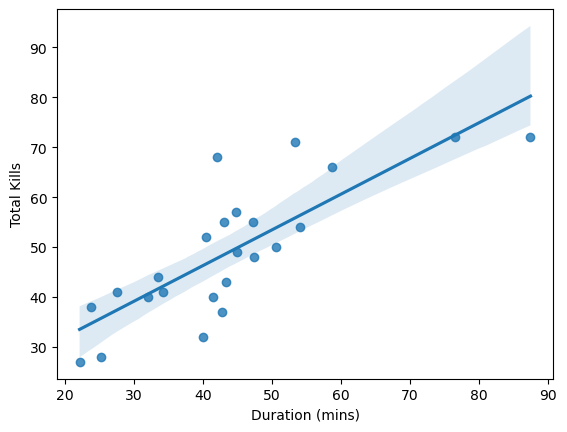

In [70]:
sns.regplot(data=finals_matches, x='Duration (mins)', y='Total Kills');

In [105]:
actual_kills = finals_matches['Total Kills'].sum()
# kills = intercept (with error) + duration (secs, with error) * total duration (secs)
cl95_kills_bot = round(
    lr_fit.params['Intercept'] - 1.96 * lr_fit.bse['Intercept']
    + (lr_fit.params['Q("Duration (secs)")'] - 1.96* lr_fit.bse['Q("Duration (secs)")']) * cl95_games_bot * (avg_duration - std_duration)
)
cl68_kills_bot = round(
    lr_fit.params['Intercept'] - lr_fit.bse['Intercept']
    + (lr_fit.params['Q("Duration (secs)")'] - lr_fit.bse['Q("Duration (secs)")']) * cl68_games_bot * (avg_duration - std_duration/2)
)
cl68_kills_top = round(
    lr_fit.params['Intercept'] - lr_fit.bse['Intercept']
    + (lr_fit.params['Q("Duration (secs)")'] + lr_fit.bse['Q("Duration (secs)")']) * cl68_games_top * (avg_duration + std_duration/2)
)
cl95_kills_top = round(
    lr_fit.params['Intercept'] + 1.96 * lr_fit.bse['Intercept']
    + (lr_fit.params['Q("Duration (secs)")'] + 1.96* lr_fit.bse['Q("Duration (secs)")']) * cl95_games_top * (avg_duration + std_duration)
)

In [108]:
games_worth['Total Kills'] = [cl95_kills_bot, cl68_kills_bot, actual_kills, cl68_kills_top, cl95_kills_top]

games_worth['Cost per Kill ($)'] = round(event_cost / games_worth['Total Kills'], 2)

The estimations of the kills are of course very wild and varied, since I'm using confidence intervals initially on the number of games, then on the game length, and finally, on the kills.

In [109]:
games_worth

,Stat,Number of Games,Total Duration (secs),Total Duration,Cost per Game ($),Cost per Minute ($),Cost per Hour ($),Total Kills,Cost per Kill ($)
0,95% lower bound,23,39729.272489,0 days 11:02:09,38.26,1.33,79.75,336,2.62
1,68% lower bound,25,54595.641751,0 days 15:09:56,35.20,0.97,58.03,561,1.57
2,Actual,24,63367.000000,0 days 17:36:07,36.67,0.83,50.00,1180,0.75
3,68% upper bound,28,86709.214572,1 days 00:05:09,31.43,0.61,36.54,1208,0.73
4,95% upper bound,30,106596.709797,1 days 05:36:37,29.34,0.50,29.72,1689,0.52


I could do estimations per day, but the ticket was sold for all 3 days together. Still, just looking at a few more stats here for completeness, the average kills per day and the average game length.

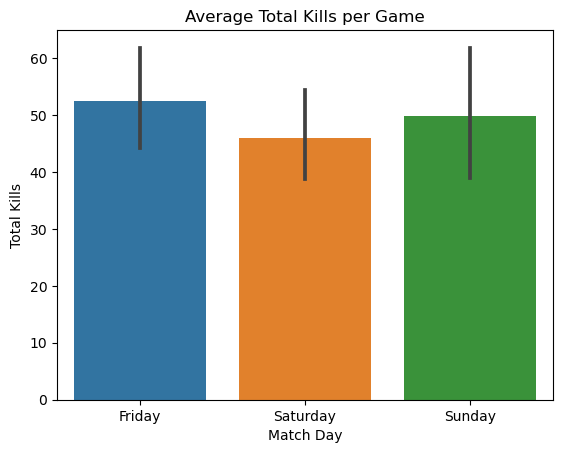

In [244]:
sns.barplot(finals_matches, x='Match Day', y='Total Kills', order=['Friday', 'Saturday', 'Sunday']).set(title='Average Total Kills per Game');

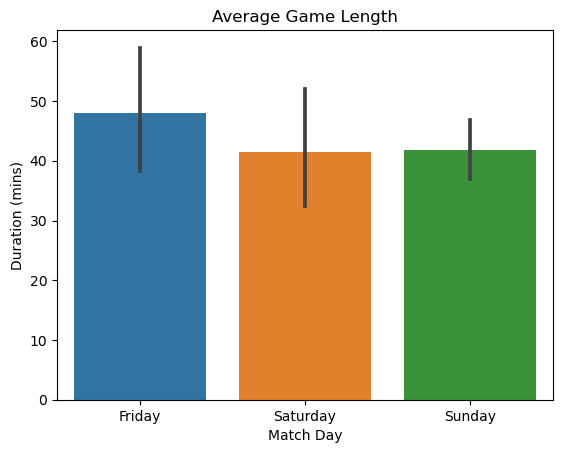

In [245]:
sns.barplot(finals_matches, x='Match Day', y='Duration (mins)', order=['Friday', 'Saturday', 'Sunday']).set(title='Average Game Length');

How often does more kills mean the team wins?

In [80]:
finals_matches['Kill Difference'] = (
    np.where(finals_matches['Radiant Kills'] == finals_matches['Dire Kills'], 'Draw',
    np.where(finals_matches['Radiant Kills'] > finals_matches['Dire Kills'], 'Radiant', 'Dire'))
)

- When Radiant had the most kills, they won 100% of the time
- When the kills were equal, the Dire won
- When Dire had the most kills, they won 85% of the time

In [81]:
finals_matches.groupby(['Kill Difference', 'Winner'])['Match ID'].count()

Kill Difference  Winner 
Dire             Dire       11
                 Radiant     2
Draw             Dire        1
Radiant          Radiant    10
Name: Match ID, dtype: int64

In [82]:
print(f"Overall, the team that got most kills won {100*len(finals_matches.loc[finals_matches['Kill Difference'] == finals_matches['Winner']])/len(finals_matches)}% of time")


Overall, the team that got most kills won 87.5% of time


## Value of Fandom

What if I'm only paying (in my mind) for watching my team. How much will each of the matches they play cost?

The two extremes are:
- My team looses right away, in a 0:2 and gets eliminated
- My team wins all the way to the grand final, each series is a 2:1 and the finals ends in 3:2 (or 2:3, making me highly upset for my team)
- it could also happen that my team begins in the upper brackets, loses the first match 1:2 and then continues same as in the point above

So at least, they'll play 2 games, at most, 17 which is a massive difference! If we're paying per length of game, that's variable since it can be quite different (avg. is about 44 min and st dev. 15 min). For the sake of comparing extremes, for the sake of comparisons, I'll use the mean - std values for the team being eliminated right away, and mean + std for the team winning through (just to minimize and maximize time played). I'll compare that with the actual tournament least and most.

In [130]:
team_stats =[]

for team_name in teams_list:

    team_matches = finals_matches.loc[(finals_matches['Radiant Team'] == team_name)| (finals_matches['Dire Team'] == team_name)].copy()
    
    team_radiant_games = len(finals_matches.loc[finals_matches['Radiant Team'] == team_name])
    team_dire_games = len(finals_matches.loc[finals_matches['Dire Team'] == team_name])

    team_radiant_wins = len(finals_matches.loc[((finals_matches['Radiant Team'] == team_name) & (finals_matches['Winner'] == 'Radiant'))])
    team_dire_wins = len(finals_matches.loc[((finals_matches['Dire Team'] == team_name) & (finals_matches['Winner'] == 'Dire'))])
    
    team_radiant_kills = finals_matches.loc[finals_matches['Radiant Team'] == team_name, 'Radiant Kills'].sum()
    team_radiant_deaths = finals_matches.loc[finals_matches['Radiant Team'] == team_name, 'Dire Kills'].sum()
    team_dire_kills = finals_matches.loc[finals_matches['Dire Team'] == team_name, 'Dire Kills'].sum()
    team_dire_deaths = finals_matches.loc[finals_matches['Dire Team'] == team_name, 'Radiant Kills'].sum()

    team_radiant_playtime = team_matches.loc[finals_matches['Radiant Team'] == team_name,'Duration (secs)'].sum()
    team_dire_playtime = team_matches.loc[finals_matches['Dire Team'] == team_name,'Duration (secs)'].sum()

    team_stats.append([team_name, team_radiant_games, team_dire_games, team_radiant_games + team_dire_games,
                       round(100*team_radiant_wins/team_radiant_games,2),
                       round(100*team_dire_wins/team_dire_games,2),
                       team_radiant_kills, team_radiant_deaths,
                       team_dire_kills, team_dire_deaths,
                       team_radiant_kills + team_dire_kills,
                       team_radiant_deaths + team_dire_deaths,
                       round(team_radiant_playtime/(60*team_radiant_games),2),
                       round(team_dire_playtime/(60*team_dire_games),2),
                       team_radiant_playtime + team_dire_playtime])



In [131]:
team_stats = pd.DataFrame(team_stats, columns=['Team Name', 'Radiant Games', 'Dire Games', 'Total Games', 'Radiant Win PCT', 'Dire Wins PCT', 'Radiant Kills', 'Radiant Deaths', 'Dire Kills', 'Dire Deaths', 'Total Kills', 'Total Deaths', 'Team Radiant Play Time Per Game (mins)', 'Team Dire Play Time Per Game (mins)', 'Total Play Time (secs)'])

In [132]:
team_stats.columns[(team_stats.columns.str.contains('Radiant')) & (~team_stats.columns.str.contains('Radiant Games'))]

Index(['Radiant Win PCT', 'Radiant Kills', 'Radiant Deaths',
       'Team Radiant Play Time Per Game (mins)'],
      dtype='object')

In [133]:
team_stats

,Team Name,Radiant Games,Dire Games,Total Games,Radiant Win PCT,Dire Wins PCT,Radiant Kills,Radiant Deaths,Dire Kills,Dire Deaths,Total Kills,Total Deaths,Team Radiant Play Time Per Game (mins),Team Dire Play Time Per Game (mins),Total Play Time (secs)
0,Gaimin Gladiators,7,5,12,71.43,60.00,189,115,106,97,295,212,34.63,36.81,25587
1,Team Spirit,2,6,8,100.00,83.33,68,58,197,148,265,206,48.16,48.97,23409
2,LGD Gaming,3,3,6,0.00,66.67,80,97,75,62,155,159,58.09,44.04,18383
3,Azure Ray,4,3,7,25.00,33.33,77,121,30,85,107,206,43.23,32.85,16288
4,BetBoom Team,3,2,5,66.67,50.00,88,38,71,67,159,105,39.93,73.06,15955
5,Team Liquid,3,3,6,66.67,0.00,71,78,58,94,129,172,45.94,40.74,15604
6,Virtus.pro,1,1,2,0.00,0.00,36,36,13,36,49,72,87.43,44.97,7944
7,nouns,1,1,2,0.00,0.00,8,20,13,28,21,48,25.15,34.25,3564


Now let's break it down! First contrasting the least and most bang for your buck - measured in how much time a team has spent playing!

First, I need to check what is the difference in kills between winning and losing team. As per below, it appears to be about from about 9 to 16 kills difference. As indicated by the warning, however, there are multicolinearity effects - naturally, the shortest the game is, the more one sided it may be, versus the longest it is, the more even in terms of kills.

In [150]:
finals_matches['Winner Kills'] = np.where(finals_matches['Winner'] == 'Radiant', finals_matches['Radiant Kills'], finals_matches['Dire Kills'])
finals_matches['Loser Kills'] = np.where(finals_matches['Winner'] == 'Radiant', finals_matches['Dire Kills'], finals_matches['Radiant Kills'])

kill_data = finals_matches.melt(id_vars=['Match ID', 'Duration (secs)'], value_vars=['Winner Kills', 'Loser Kills'])

smf.ols('value ~ Q("Duration (secs)") + variable', data = kill_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     39.12
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           1.43e-10
Time:                        13:02:00   Log-Likelihood:                -155.34
No. Observations:                  48   AIC:                             316.7
Df Residuals:                      45   BIC:                             322.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.7215      3.006      0.905      0.370      -3.332       8.775
variable[T.Winner Kills]    12.2500      1.835      6.675      0.000       8.553      15.947
Q("Duration (secs)")         0.0060      0.001      5.805      0.000       0.004       0.008
==============================================================================
Omnibus:                        1.876   Durbin-Watson:                   2.618
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.819
Skew:                           0.424   Prob(JB):                        0.403
Kurtosis:                       2.563   Cond. No.                     9.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Initially I thought 12 kills difference is going to be a decent enough approximation, given all the other concessions made so far. However, after plugging that in for a team that lost 2:0, I got a negative value, lol. On the other hand, for FLESH WOUND I got too little kills compared to some other teams. Solution: ignore this coeff. for the "quick" loser, and keep an additional 12 for about half of the games that FLESH WOUND plays (in losses, they probably won't have plus 12). 
- `SHRUBBERY` as a team that loses 2:0 (using the lower 95% cl bound for game length)
- `ITS JUST A FLESH WOUND` as a team that always wins 2:1, or 3:2 in finals, playing the maximum number of games (17 games - 11 wins, 6 loses, using upper bound 95% cl for game length)

In [226]:
games_worth

,Stat,Number of Games,Total Duration (secs),Total Duration,Cost per Game ($),Cost per Minute ($),Cost per Hour ($),Total Kills,Cost per Kill ($)
0,95% lower bound,23,39729.272489,0 days 11:02:09,38.26,1.33,79.75,336,2.62
1,68% lower bound,25,54595.641751,0 days 15:09:56,35.20,0.97,58.03,561,1.57
2,Actual,24,63367.000000,0 days 17:36:07,36.67,0.83,50.00,1180,0.75
3,68% upper bound,28,86709.214572,1 days 00:05:09,31.43,0.61,36.54,1208,0.73
4,95% upper bound,30,106596.709797,1 days 05:36:37,29.34,0.50,29.72,1689,0.52


In [227]:
team_worth = team_stats[['Team Name','Total Games', 'Total Play Time (secs)', 'Total Kills']].copy()

# for consistency
team_worth = team_worth.rename(columns={'Total Games': 'Number of Games', 'Total Play Time (secs)': 'Total Duration (secs)'})

In [228]:
shrub_games = 2 
shrub_duration = shrub_games * (avg_duration - std_duration)
shrub_kills = round(
    (lr_fit.params['Intercept'] - 1.96 * lr_fit.bse['Intercept']
    + (lr_fit.params['Q("Duration (secs)")'] - 1.96* lr_fit.bse['Q("Duration (secs)")'])* shrub_games * (avg_duration - std_duration)
    ) / 2
)

fwound_games = 17
# for winning team, the # kills = # kills per game / 2 + 12
fwound_duration = fwound_games * (avg_duration + std_duration)
fwound_kills = round(
    (lr_fit.params['Intercept'] + 1.96 * lr_fit.bse['Intercept']
    + (lr_fit.params['Q("Duration (secs)")'] + 1.96* lr_fit.bse['Q("Duration (secs)")'])* fwound_games * (avg_duration + std_duration)
    ) / 2 + fwound_games * 7
)

In [229]:
team_worth.loc[8] = ['SHRUBBERY', shrub_games, shrub_duration, shrub_kills]
team_worth.loc[9] = ['ITS JUST A FLESH WOUND', fwound_games, fwound_duration, fwound_kills]

In [231]:
team_worth['Total Duration'] = pd.to_timedelta(team_worth['Total Duration (secs)'], 's').round('s')

team_worth['Cost per Game ($)'] = round(event_cost / team_worth['Number of Games'], 2)
team_worth['Cost per Minute ($)'] = round(event_cost * 60/ team_worth['Total Duration (secs)'], 2)
team_worth['Cost per Hour ($)'] = round(event_cost * 3600/ team_worth['Total Duration (secs)'], 2)
team_worth['Cost per Kill ($)'] = round(event_cost / team_worth['Total Kills'], 2)

In [232]:
team_worth

,Team Name,Number of Games,Total Duration (secs),Total Kills,Total Duration,Cost per Game ($),Cost per Minute ($),Cost per Hour ($),Cost per Kill ($)
0,Gaimin Gladiators,12,25587.000000,295,0 days 07:06:27,73.34,2.06,123.82,2.98
1,Team Spirit,8,23409.000000,265,0 days 06:30:09,110.01,2.26,135.34,3.32
2,LGD Gaming,6,18383.000000,155,0 days 05:06:23,146.68,2.87,172.35,5.68
3,Azure Ray,7,16288.000000,107,0 days 04:31:28,125.73,3.24,194.52,8.23
4,BetBoom Team,5,15955.000000,159,0 days 04:25:55,176.02,3.31,198.58,5.54
5,Team Liquid,6,15604.000000,129,0 days 04:20:04,146.68,3.38,203.04,6.82
6,Virtus.pro,2,7944.000000,49,0 days 02:12:24,440.04,6.65,398.83,17.96
7,nouns,2,3564.000000,21,0 days 00:59:24,440.04,14.82,888.97,41.91
8,SHRUBBERY,2,3454.719347,18,0 days 00:57:35,440.04,15.28,917.09,48.89
9,ITS JUST A FLESH WOUND,17,60404.802218,603,0 days 16:46:45,51.77,0.87,52.45,1.46


## Summary

In [241]:
games_worth.drop(columns=['Total Duration (secs)'])[['Stat', 'Number of Games', 'Total Kills', 'Total Duration', 'Cost per Game ($)', 'Cost per Minute ($)', 'Cost per Hour ($)', 'Cost per Kill ($)']]

,Stat,Number of Games,Total Kills,Total Duration,Cost per Game ($),Cost per Minute ($),Cost per Hour ($),Cost per Kill ($)
0,95% lower bound,23,336,0 days 11:02:09,38.26,1.33,79.75,2.62
1,68% lower bound,25,561,0 days 15:09:56,35.20,0.97,58.03,1.57
2,Actual,24,1180,0 days 17:36:07,36.67,0.83,50.00,0.75
3,68% upper bound,28,1208,1 days 00:05:09,31.43,0.61,36.54,0.73
4,95% upper bound,30,1689,1 days 05:36:37,29.34,0.50,29.72,0.52


In [240]:
team_worth.drop(columns=['Total Duration (secs)'])

,Team Name,Number of Games,Total Kills,Total Duration,Cost per Game ($),Cost per Minute ($),Cost per Hour ($),Cost per Kill ($)
0,Gaimin Gladiators,12,295,0 days 07:06:27,73.34,2.06,123.82,2.98
1,Team Spirit,8,265,0 days 06:30:09,110.01,2.26,135.34,3.32
2,LGD Gaming,6,155,0 days 05:06:23,146.68,2.87,172.35,5.68
3,Azure Ray,7,107,0 days 04:31:28,125.73,3.24,194.52,8.23
4,BetBoom Team,5,159,0 days 04:25:55,176.02,3.31,198.58,5.54
5,Team Liquid,6,129,0 days 04:20:04,146.68,3.38,203.04,6.82
6,Virtus.pro,2,49,0 days 02:12:24,440.04,6.65,398.83,17.96
7,nouns,2,21,0 days 00:59:24,440.04,14.82,888.97,41.91
8,SHRUBBERY,2,18,0 days 00:57:35,440.04,15.28,917.09,48.89
9,ITS JUST A FLESH WOUND,17,603,0 days 16:46:45,51.77,0.87,52.45,1.46
